From linear models to machine learning [workbook]
===
- Machine learning can be intimidating, but all of the most complex concepts can be broken down into single, less complex chunks. The complexity from ML techniques emerges when we take simple blocks and chain them together.
- No technique embodies this more than neural networks - powerful universal function approximators, driving the current state of the art in ML.
- Broken down to their simplest unit, the 'neuron', these networks are nothing more than combinations of simple non-linear units, with the emergent complexity coming from chaining arbitrary numbers of them together. This is not helped by current ML frameworks abstracting this away under `Layer` APIs and wrapping the entire training process under `model.fit()` or similar.

- This notebook starts off in (hopefully) familiar territory of linear models (straight line fits), and builds on these to build simple neural networks from scratch.
- We will use the [JAX](https://jax.readthedocs.io/en/latest/) linear algebra framework to power this, essentially `numpy`-like syntax, but with powerful automatic differentiation and compilation routines. This can provide C-level performance, but with the nice programming experience we're all familiar with

In this notebook:
- We will build and train from scratch a simple neural network, to demystify the process and build intuition for how such networks work, train, and classify.
- We will apply this neural network to astronomical data.
- Features, feature extraction, PCA

_Note:_ some examples in this notebook are deliberately written in a slow way. For example, we can easily parallelise evaluation of batches with correct JAX/numpy broadcasting rules, but here I write some examples explicitly ignoring this, for clarity of explanation! This is why we use ML frameworks - to abstract away implementation details.

**This is the workbook edition**: most cells will throw a `NotImplementedError` if you haven't made the changes to make them run - these should be challenging but rewarding to complete, and you can always refer to the full versions if you get stuck.

In [25]:
from datetime import date

import jax
import pandas as pd
from astropy.io import fits

jax.config.update("jax_enable_x64", True)  # force JAX to use 64-bit mode
jnp = jax.numpy

# init our RNG key, for later.
rng_key = jax.random.PRNGKey(42)

import matplotlib.pyplot as plt

Linear models
---
Let's start right at the beginning, with among the simplest statistical regression models that comes to mind.

The first step is to generate a test dataset - see below:
- Generate a dataset corresponding to a straight line. The parameters `m_true` and `b_true` correspond to the gradient and intercept. Store the result in `y_true`.
- Add some noise to this dataset (hint, you can generate noise with the `jax.random.normal` command).

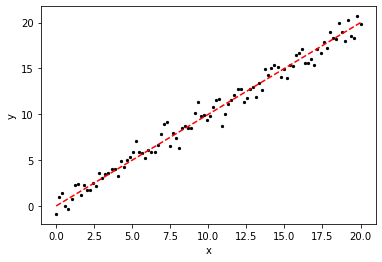

In [26]:
x = jnp.linspace(0, 20, 100)
m_true = 1
b_true = 0


y_true = None
y_obs = None

if (y_true is None) | (y_obs is None):
    raise NotImplementedError("Add the straight line model and noise first!")

plt.scatter(x, y_obs, c='k', s=5)
plt.plot(x, y_true, c='r', ls='--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Analytic solution (linear least squares)
---
In the case of linear models, we're lucky that an analytic solution exists -- linear least squares.
We can write the model above as a matrix equation.

$$ \bf{A}x = \bf{b}$$
where $A$ is the 'design' matrix, and takes the form
$$ \begin{pmatrix}1 & x_0 \\1 & x_1 \\1 & x_2 \\\vdots & \vdots \\1 & x_n \\\end{pmatrix}$$
and the values of $b$ represent the y-values of our points.
$x$ is what we are solving for, and contains the coefficients which when multiplied with $A$ minimise $||Ax - b||$, where $|| ||$ denotes the squared mean.

The analytical solution can be written as
$$x = (\bf{A}^{T} \bf{A})^{-1} \bf{A}^{T} \bf{b} $$

Note in the cells below, the `@` operator is infix notation to denote matrix multiplication. You can read `a @ b` as `np.matmul(a, b)` if it helps with understanding.

**In this cell:** implement the analytical solution above to solve for the line coefficients. You may need the `jnp.linalg.inv` and `.T` operators!

In [3]:
# let's build the design matrices according to the specification above
design_matrix = jnp.array([jnp.ones_like(x), x]).T
obs_matrix = y_obs[jnp.newaxis, :].T

0.205
0.986


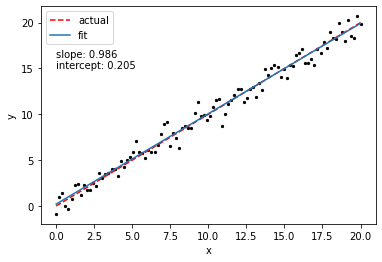

In [4]:
# Thankfully, there's a convenience function to compute this for us
coeffs, _, _, _ = jnp.linalg.lstsq(design_matrix, obs_matrix)

# Essentially this does the below under the hood - the `lstsq` function does things more cleverly to avoid singular matrices and speeds things up with Cholesky decomposition
coeffs_handcoded = None

if coeffs_handcoded is None:
    raise NotImplementedError("Add the least-squares solution first")

y_pred = design_matrix @ coeffs_handcoded

for c in coeffs.flatten():
    print(f"{c:.3f}")

plt.scatter(x, y_obs, c='k', s=5)
plt.plot(x, y_true, c='r', ls='--', label='actual')
plt.plot(x, y_pred, c='C0', ls='-', label='fit')

_intercept, _slope = coeffs_handcoded.flatten()
plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Some observations
---
- Note that we do not exactly recover the coefficients we put in (i.e. `m_true`, `b_true`) in the cell where we create the dataset. This is because we added noise, and least squares does not recover a unique set of coefficients, only those that minimise the Euclidean norm of the residuals.
- How far off are we from the values you chose above?

Numerical solution
---
- Sometimes we may not have linear solutions to our problems - i.e. in the most general case, any non-separable model is significantly more difficult to solve. Here we need to turn to iterative methods.

- In the following section, we introduce a few concepts which we'll come back to continually through this workshop. Don't worry if you don't fully follow now, we'll come back to these and elaborate further.

<div class="alert alert-block alert-info">
<b>Loss function</b>

The loss function is a general concept in machine learning, and evaluates how well a given model's predictions correspond to the dataset it is trying to approximate. Generally, the lower the value of the loss function, the better the fit. This is also known as the cost function or error function.
As astronomers, you're likely already familiar with one cost function: the chi-squared statistic. This function takes a specific set of parameters, makes a model prediction, and compares this to some input data to compute the 'goodness of fit'. By minimising the 'cost', we find the best-fitting parameters.
The chi-squared statistic has a close relative in the ML literature: the L2 or mean-squared error loss. This can be written as
$$ \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
where $y_i$ is the ith datapoint, and $\hat{y}_i$ is the model's prediction for the ith datapoint.
We will implement the mean squared error loss below, but there are many more loss functions, including for classification tasks, which we will come to later.
</div>

**In this cell:** implement the straight line model, and the mean-squared error loss function

In [2]:
def linear_model(pars, x, y):
    m, c = pars
    return None

def loss_function(pars, x, y):
    y_model = linear_model(pars, x, y)
    return None

if linear_model([None, None], None, None) is None:
    raise NotImplementedError("Implement the linear model first!")

if loss_function([None, None], None, None) is None:
    raise NotImplementedError("Implement the loss function first!")

NotImplementedError: Implement the linear model first!

For this section, let's analytically compute the derivatives! Don't worry, this is just to show you what's going on - `JAX` can do this automatically for us going forward.

$$ \frac{d\mathcal{L}}{dm} = -2\sum_{i=1}^{N} (y_i - \hat{y}_i) x$$
$$ \frac{d\mathcal{L}}{dc} = -2\sum_{i=1}^{N} (y_i - \hat{y}_i)$$

In [3]:
def dloss_dm(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y - y_model)*x)

def dloss_dc(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y - y_model))

# to make this easier to follow, let's write a function that returns these as an array.
def dloss_vec(pars, x, y):
    dldm = dloss_dm(pars, x, y)
    dldc = dloss_dc(pars, x, y)

    return jnp.array([dldm, dldc])

Gradient descent
---
- We now have a loss function, and gradients of it with respect to our parameters. Now to optimise the parameters using gradient descent.

<div class="alert alert-block alert-info">
<b>Gradient descent</b>

Gradient descent is a first-order (in gradient) optimisation technique used to minimise functions.

At each iteration $i$, the next position is computed according to the following update rule:
$$ x_{i+1} = x_{i} - \eta \nabla f(x_{i})$$
where $\eta$ is a dimensionless quantity known as the 'learning rate', which controls the size of the steps taken, and $\nabla f(x_{i})$ is the gradient of $f$ with respect to $x$ at the current timestep.
</div>

- See the gradient descent notebook for a fuller description of gradient descent, along with more complex discussion of the steps below

**In this cell:** Implement the gradient descent step above, inside the loop.

0 steps: loss 115.848 / gradnorm: 248.966


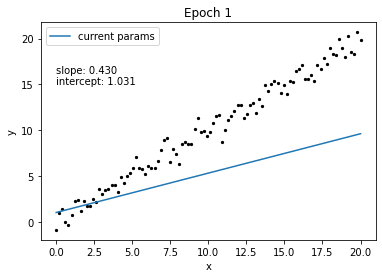

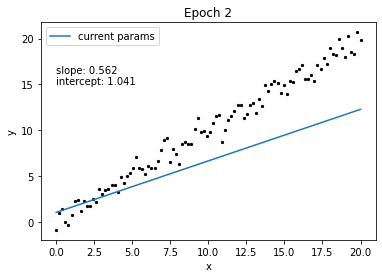

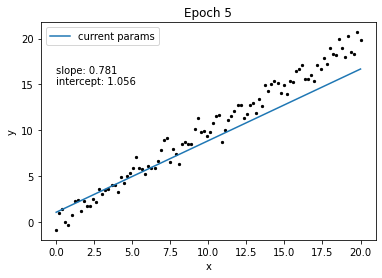

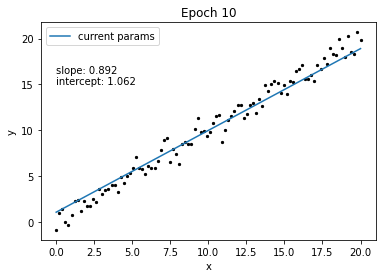

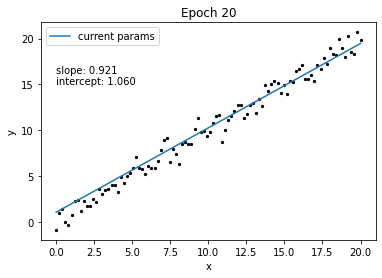

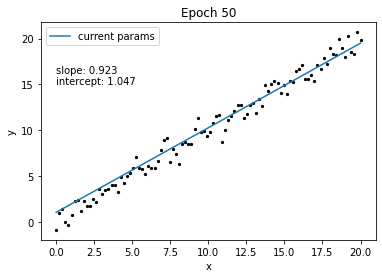

In [37]:
m_init = 0
c_init = 1
init_pars = jnp.array([m_init, c_init])
_pars = init_pars

eta = None
n_optimisation_steps = None

if (eta is None) | (n_optimisation_steps is None):
    raise NotImplementedError("Need to choose suitable eta and n_steps")

loss_arr = jnp.zeros(n_optimisation_steps)
grad_arr = jnp.zeros(n_optimisation_steps)

for n in range(n_optimisation_steps):
    _loss = loss_function(_pars, x, y_obs)
    loss_arr = loss_arr.at[n].set(_loss)

    _loss_grads = dloss_vec(_pars, x, y_obs)
    grad_arr = grad_arr.at[n].set(jnp.linalg.norm(_loss_grads))

    try:
        _pars -= None
    except Exception as e:
        print(e)
        raise NotImplementedError("Gradient step not implemented")

    if not (n % 100):
        print(f"{n} steps: loss {_loss:.3f} / gradnorm: {jnp.linalg.norm(_loss_grads):.3f}")

    # plot at specific intervals
    if n in [1, 2, 5, 10, 20, 50, 100]:
        _slope, _intercept = _pars
        plt.scatter(x, y_obs, c='k', s=5)
        plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
        plt.plot(x, _intercept + _slope*x, label='current params')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Epoch {n}")
        plt.legend()
        plt.show()

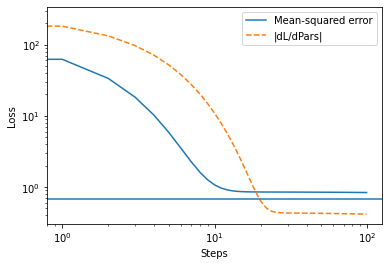

In [38]:
analytic_loss = loss_function([m_true, b_true], x, y_obs)

plt.plot(loss_arr, label='Mean-squared error')
plt.plot(grad_arr, ls='--', label='|dL/dPars|')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.axhline(analytic_loss)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

Stochastic gradient descent
---
- What happens when our model/data is big and evaluating it across a large number of samples becomes prohibitively expensive?
- Inverting a matrix (as required for least squares in the $(X^T X)^{-1}$ step) has algorithmic complexity of $O(N^3)$ - this means that if we double the number of matrix elements $N$, the computational time/number of operations is multiplied by 8! This quickly becomes an issue for linear models with large numbers of datapoints or numbers of regressors.
- Similarly, in the case of large datasets, we have to compute gradients and losses for large numbers of points.

- We can use [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), computing our losses and gradients using a **subsample** of points to average.

Below we implement this for the previous example to verify it works! We choose a batch size of 8 - i.e. averaging over 8 points to get our gradients out.

**In this cell:** Implement the batching code - you will need to use `jax.random.choice` in this.

0 steps: loss 32.482 / gradnorm: 74.145


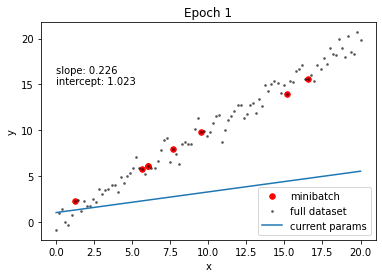

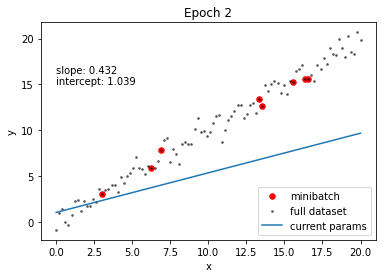

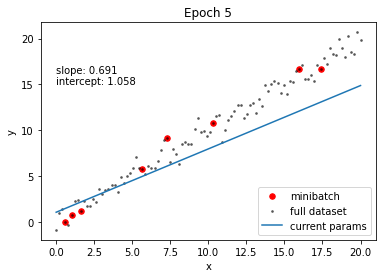

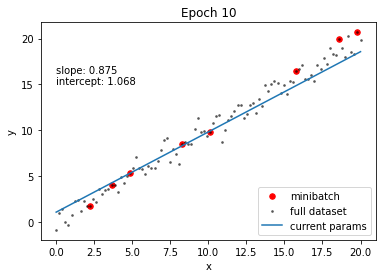

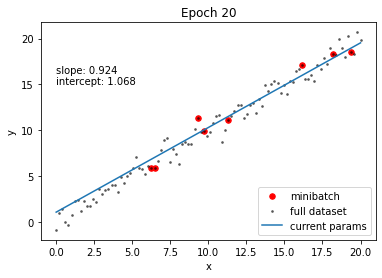

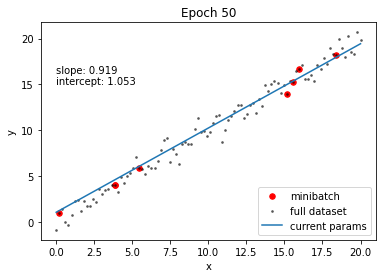

In [41]:
m_init = 0
c_init = 1
init_pars = jnp.array([m_init, c_init])
_pars = init_pars

eta = 1e-3
n_optimisation_steps = 100
batch_size = 8

# because of how JAX randomness works, declare a key here for this cell.
sgd_rng_key = jax.random.PRNGKey(42)
dataset_idxs = jnp.arange(len(x))

loss_arr_stoch = jnp.zeros(n_optimisation_steps)
grad_arr_stoch = jnp.zeros(n_optimisation_steps)

for n in range(n_optimisation_steps):
    x_batch = None
    y_batch = None

    if (x_batch is None) | (y_batch is None):
        raise NotImplementedError("Need to add the batching code!")

    _, sgd_rng_key = jax.random.split(sgd_rng_key)

    _loss_stoch = loss_function(_pars, x_batch, y_batch)
    loss_arr_stoch = loss_arr_stoch.at[n].set(_loss_stoch)

    _loss_grads_stoch = dloss_vec(_pars, x_batch, y_batch)
    grad_arr_stoch = grad_arr_stoch.at[n].set(jnp.linalg.norm(_loss_grads_stoch))
    _pars -= eta * _loss_grads_stoch

    if not (n % 100):
        print(f"{n} steps: loss {_loss_stoch:.3f} / gradnorm: {jnp.linalg.norm(_loss_grads_stoch):.3f}")

    # plot at specific intervals
    if n in [1, 2, 5, 10, 20, 50, 100]:
        _slope, _intercept = _pars
        plt.scatter(x_batch, y_batch, c='red', s=30, label='minibatch')
        plt.scatter(x, y_obs, c='k', s=3, alpha=0.5, label='full dataset')
        plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
        plt.plot(x, _intercept + _slope*x, label='current params')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Epoch {n}")
        plt.legend(loc='lower right')
        plt.show()


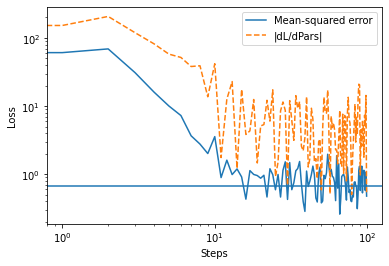

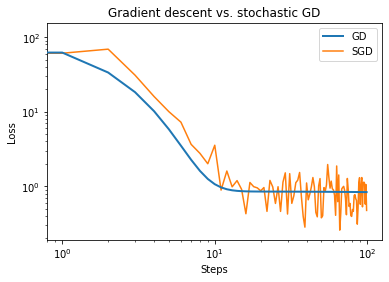

In [42]:
analytic_loss = loss_function([m_true, b_true], x, y_obs)

plt.plot(loss_arr_stoch, label='Mean-squared error')
plt.plot(grad_arr_stoch, ls='--', label='|dL/dPars|')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.axhline(analytic_loss)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(loss_arr, zorder=20, lw=2, label='GD')
plt.plot(loss_arr_stoch, label='SGD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Gradient descent vs. stochastic GD")
plt.show()

We see here that the loss function from stochastic gradient descent tracks exactly the loss from gradient descent on the full dataset (albeit with noise). This is great! We can optimise large datasets (such as those used in machine learning) by taking samples (or _batches_) and computing our loss/gradient on them instead.

So what does all of this have to do with machine learning?
---
- With this diversion we've covered how to build a (linear) model, choosing a loss function, optimising said loss function using stochastic gradient descent, and why we might want to do this.
- The next chunk of the notebook focuses on how we bridge from these basic linear models to building neural networks.

- In a sense we've already written the most basic neural network - it's just missing what we call an 'activation function' to make it non-linear. This is still not really machine learning - statisticians call this class of models 'generalised linear models' and they're useful for a wide variety of tasks.

Building a generalised linear model to estimate completeness in astronomical data
-----
Let's build a simple GLM to estimate the probability of having detected a given source in astronomical data. This is also known as [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) and is commonplace in statistics. There are already libraries that can do this for us, but that's no fun!

As input, our model takes some parameters (here the flux of a given object), and predicts as output the _probability_ of recovering a source at that magnitude. Our "labels" will have the form (magnitude, recovered) where magnitude is a continuous variable, and recovered is a binary 0/1 (or no/yes) label.

To specify our generalised linear model we need two things:
- A _link function_, that nonlinearly transforms our input linear model in some way.
- A loss/likelihood function to optimise.

Given a dataset and (probabilistic) predictions from a model, we can compute the cross-entropy between the two (effectively measuring the disagreement as a loss term)
This model has no closed-form analytic solution and thus here we _need_ to use our gradient descent from above!

Specifically for this model, our prediction function is

$$ y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} $$

and our loss function is the binary cross-entropy - see the slides for a fuller discussion of this.

$$ \mathcal{L} = -y_{true} \log_{2}{y_{pred}} - (1 - y_{true}) \log_{2}{(1 - y_{pred})}$$

**In this cell:** implement the logistic function above

In [ ]:
def logistic_function(pars, x):
    beta_0, beta_1 = pars
    return None

if logistic_function([None, None], None) is None:
    raise NotImplementedError("Implement the logistic function!")

def loss_function(pars, x, y):
    model_preds = logistic_function(pars, x)
    xent_loss = -(y * jnp.log(model_preds) + (1 - y) * jnp.log(1 - model_preds))
    return jnp.mean(xent_loss)

# Now let's switch to automatic differentation and avoid having to do more calculus.
log_value_and_grad = jax.jit(jax.value_and_grad(loss_function, argnums=0))

Data wrangling
---
Does our data look right? We need to do some quality control and double check what we might expect to get. Below let's:
- Load in our data
- Apply a cut to reject bright sources (because there detection is affected by effects like saturation)
- Compute a histogram of recovery as a function of magnitude - this is essentially what we're trying to recover but in a bin-free way.

In [ ]:
goto_data = pd.read_csv("../data/tns_goto_xmatch_excerpt.csv")
goto_data = goto_data.iloc[goto_data.mag.values > 16.5]

plt.scatter(goto_data['mag'], goto_data['realbogus'] > 0.7, marker='x')

recovery_bins = []
recovery_err_bins = []
magstep = 0.5

for m in (mag_per_bin := jnp.arange(goto_data['mag'].values.min(), goto_data['mag'].values.max(), magstep)):
    mask = (m < goto_data['mag'].values) & (goto_data['mag'].values < m+magstep)
    n_recovered_per_bin = jnp.sum(goto_data['realbogus'].values[mask] > 0.7)
    n_total_dets_per_bin = jnp.sum(mask)
    recovery_bins.append(n_recovered_per_bin / n_total_dets_per_bin)
    recovery_err_bins.append(jnp.sqrt(n_recovered_per_bin) / n_total_dets_per_bin)

plt.plot(mag_per_bin, recovery_bins)
plt.xlabel("Magnitude of source")
plt.ylabel("Recovery fraction per bin")

Now for the model:

**In this cell, write a convergence test to stop the model if the loss stops decreasing step after step (within some tolerance of your choice).

In [ ]:
dataset_x = goto_data['mag'].values
normpoint = jnp.median(goto_data['mag'].values)

# here let's say anything with a classifier score with > 0.7 is detected.
dataset_y = (goto_data['realbogus'].values > 0.7).astype(int)
plt.scatter(dataset_x, dataset_y)

plotrange = jnp.linspace(dataset_x.min(), dataset_x.max())

x0 = jnp.array([-5, -1]).astype(float)
x = x0
val, grad = log_value_and_grad(x0, dataset_x - normpoint, dataset_y)
plt.plot(plotrange, logistic_function(x0, plotrange), label='initial')

n_steps = 100000
eta = 3e-1

loss_values = [val]

for i in range(1, n_steps):
    x = x - eta*grad

    val, grad = log_value_and_grad(x, dataset_x - normpoint, dataset_y)
    loss_values.append(val)

    if not (i % 10000):
        print(f"Loss at epoch {i}: {val:.3f} \n Pars: {x}")

    # write your convergence test here
    converged = None
    if converged is None:
        raise NotImplementedError("Need to implement the convergence test! For testing, set converged to False to disable this exception")

    if converged:
        print(f"Converged after {i} iterations")
        print(f"Loss at epoch {i}: {val:.3f} \n Pars: {x}")
        break

plt.plot(plotrange, logistic_function(x, plotrange - normpoint), label='final')
plt.bar(mag_per_bin, recovery_bins, width=magstep, zorder=-1, color='green', alpha=0.5, edgecolor='k', align='edge', yerr=recovery_err_bins, error_kw={'capsize':5, 'elinewidth':1})
plt.xlabel("Magnitude")
plt.ylabel("Probability of detection")
plt.legend()

Key takeaway:
---
This is just a linear model wrapped in a non-linear function, e.g. $\sigma(z)$, where $z = \beta_0 + \beta_1 x$, yet we're able to model more complex problems this way.
Without telling you, you've also just seen the simplest non-trivial neural network in action - this is a single neuron classifier.

We're nearly ready to build our first deep neural net.

The neuron
---
- Neurons are the simplest possible unit of a fully-connected neural network. They look very similar to the linear model we just created - the terminology is slightly different but the principles are the same.
- Neurons take inputs, multiply them by a weight and sum, apply a bias term, and then 'rectify' the output using an 'activation function'
- Our linear models take inputs, multiply them by coefficients (the 'slopes' $m_i$), add a bias term (the 'intercepts' $b_i$), and sum this to get the output variable.

A single neuron takes an input $y^{in}$, multiplies it by a weight $w$, adds a bias term $b$, and then feeds this ($z$) through a non-linear function $f(z)$ to get $y_{out}$

Mathematically, we can write the 'forward pass' as:
$ z_j = \sum_{k} w_{jk} y^{in}_{k} + b_{j}$
$ y^{out}_{j} = f(z_j)$
where $k$ represents the number of inputs, and $j$ represents the number of outputs

In a more intuitive way however, we can think of this as multi-variable versions of what we implemented above. Neural networks at their heart are stacks of non-linear models, and 'deep' neural networks are just many non-linear models fed to each-other in sequence. It's the emergent complexity that leads to deep learning being so powerful.

Let's focus now on re-implementing the logistic regression classifier above in a more neural-network flavoured syntax - we're nearly there!

Re-implementing our logistic regression in a more neural-network flavoured syntax
- Let's bring it all together - train a NN classifier to predict the probability of a given source being detected in a GOTO image as a function of magnitude. We'll use SGD to save time, and use a sigmoid activation function.

**In this cell:** Choose appropriate values for the learning rate, batch size, and number of training steps. This may take some trial and error.

In [ ]:
def sigmoid(z):
    return 1/(1 + jnp.exp(-z))

def single_layer_forward_pass(wandb, x_in):
    weight, bias = wandb
    y_pred = jnp.dot(x_in, weight) + bias
    y_pred = sigmoid(y_pred)

    return y_pred

def single_layer_loss(wandb, x_in, y_true):
    model_preds = single_layer_forward_pass(wandb, x_in)
    xent_loss = -(y_true * jnp.log(model_preds) + (1 - y_true) * jnp.log(1 - model_preds))
    return jnp.mean(xent_loss)

loss_and_grad_singlelayer = jax.jit(jax.value_and_grad(single_layer_loss, argnums=0))

# skipping a lot of the boilerplate here.
n_train_steps = None
learning_rate = None
batch_size = None

if not all([n_train_steps, learning_rate, batch_size]):
    raise NotImplementedError("Need to choose values for the learning rate, batch size, and number of steps!")

init_vals = jnp.array([0, 1], dtype=float)
pars = init_vals

loss_history = []

train_rng_key = jax.random.PRNGKey(42)

for _ in range(n_train_steps):
    # let's draw a batch
    x_batch = jax.random.choice(train_rng_key, dataset_x, shape=(batch_size, ))
    y_batch = jax.random.choice(train_rng_key, dataset_y, shape=(batch_size, ))
    _, train_rng_key = jax.random.split(train_rng_key)

    loss_val, grad = loss_and_grad_singlelayer(pars, x_batch - normpoint, y_batch)
    pars = pars - learning_rate*grad
    loss_history.append(loss_val)

plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

Hidden layers and a fully-connected deep neural network
---
Now let's build a fully-fledged neural network! For this demo, we'll teach a neural net to interpolate a white dwarf spectrum from SDSS. This technique is overkill (just linearly interpolate!), but hopefully hammers home that machine learning doesn't have to be used for classifying cats and dogs - in a sense, neural networks are just (very!) high dimensional function interpolators.


Some elements of this section are adapted from [this JAX example](https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html), primarily for clarity.

In [ ]:
!wget --random-wait --limit-rate=1M  http://classic.sdss.org/dr7/algorithms/spectemplates/spDR2-020.fit -P ../data

Now let's load in the data and normalise it (so that the values are in the correct ranges)

**In this cell:** Normalise the data (wave, flux) such that their values lie between -1 and 1 (or 0 and 1 if you prefer)

In [ ]:
wdspec = fits.getdata('../data/spDR2-020.fit')
wdhdr = fits.getheader('../data/spDR2-020.fit', 0)
wave_raw = jnp.power(10, wdhdr['COEFF0'] + wdhdr['COEFF1'] * jnp.arange(wdspec.shape[1]))
wave = wave_raw

flux_raw = wdspec[0, :]
flux = flux_raw

if jnp.abs(jnp.any(flux)) > 1:
    raise NotImplementedError("Need to normalise flux!")

if jnp.abs(jnp.any(wave)) > 1:
    raise NotImplementedError("Need to normalise flux!")

plt.plot(wave_raw, flux_raw)
plt.xlabel("wavelength (angstrom)")
plt.ylabel("flux (arb units)")
plt.show()

**In this cell:** Implement the sigmoid link function we introduced above!

In [ ]:
def sigmoid(z):
    return None

if sigmoid(None) is None:
    raise NotImplementedError("Need to implement sigmoid!")

def nn_forward_pass(wandb, x_in):
    y_pred = x_in
    for weight, bias in wandb:
        y_pred = jnp.dot(y_pred, weight) + bias

    return sigmoid(y_pred)

def nn_loss(wandb, x_in, y_true):
    y_pred = nn_forward_pass(wandb, x_in)
    return jnp.sum(jnp.square(y_true - y_pred))

loss_and_grad_nn = jax.value_and_grad(nn_loss, argnums=0)

# Let's re-implement these for speed, and vectorise them so that we can evaluate on multiple targets at once.
# You could do this with broadcasting but let's take advantage of the JAX framework.
batched_predict = jax.vmap(nn_forward_pass, in_axes=(None, 0))

def batched_loss(wandb, x_in, y_true):
    return jnp.sum(jnp.square(batched_predict(wandb, x_in).flatten() - y_true))

batched_loss_and_grad = jax.jit(jax.value_and_grad(batched_loss, argnums=0))

In [50]:
nn_weight_init_key = jax.random.PRNGKey(42)

def init_weight_layer(arr_size, rng_key, norm=1e-2):
    weight_key, bias_key = jax.random.split(rng_key)
    return norm * jax.random.normal(weight_key, arr_size), norm * jax.random.normal(weight_key, (arr_size[-1], ))

layer_specifications = [1, 32, 1]
layer_keys = jax.random.split(nn_weight_init_key, len(layer_specifications))

In [51]:
from sklearn.model_selection import train_test_split

# prep dataset - let's do a similar thing to before, train on 80% of data, 10% validation, 10% test
random_seed = 42

# 80% of images for training on, 10% as test, 10% as validation
wave_train, wave_test, flux_train, flux_test = train_test_split(
    wave, flux, test_size=0.2, random_state=42
)

wave_val, wave_test, flux_val, flux_test = train_test_split(
    wave_test, flux_test, test_size=0.5, random_state=42
)

Loss at epoch 0: 2.960 	 Val loss: 32.607
Loss at epoch 500: 0.170 	 Val loss: 2.954
Loss at epoch 1000: 0.149 	 Val loss: 2.849
Loss at epoch 1500: 0.220 	 Val loss: 2.836
Loss at epoch 2000: 0.207 	 Val loss: 2.830
Loss at epoch 2500: 0.242 	 Val loss: 2.860
Loss at epoch 3000: 0.122 	 Val loss: 2.824
Loss at epoch 3500: 0.131 	 Val loss: 2.892
Loss at epoch 4000: 0.251 	 Val loss: 3.014
Loss at epoch 4500: 0.224 	 Val loss: 2.944


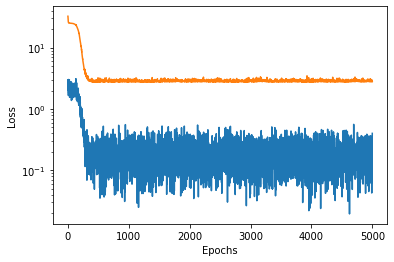

In [52]:
# train step
epochs = None
batch_size = None
eta = None

if not all([epochs, batch_size, eta]):
    raise NotImplementedError("Need to set parameters first!")

params_init = [init_weight_layer((n_in, n_out), key) for n_in, n_out, key in zip(layer_specifications[:-1], layer_specifications[1:], layer_keys)]

train_rng_key = jax.random.PRNGKey(42)
params = params_init

loss_history = []
val_loss_history = []

for n_epoch in range(epochs):
    wave_batch, flux_batch = jax.random.choice(train_rng_key, wave_train, shape=(batch_size, )), jax.random.choice(train_rng_key, flux_train, shape=(batch_size, ))
    _, train_rng_key = jax.random.split(train_rng_key)
    loss, grad = batched_loss_and_grad(params, wave_batch, flux_batch)
    loss_history.append(loss)
    params = [(w - eta * dw, b - eta * db) for (w, b), (dw, db) in zip(params, grad)]

    val_loss, _ = batched_loss_and_grad(params, wave_val, flux_val)
    val_loss_history.append(val_loss)

    if not (n_epoch % 500):
        print(f"Loss at epoch {n_epoch}: {loss:.3f} \t Val loss: {val_loss:.3f}")

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")

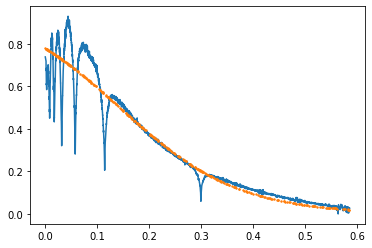

In [54]:
test_pred = batched_predict(params, wave_test)
plt.scatter(wave_test, test_pred.flatten(), c='C1', s=2, zorder=20)
plt.plot(wave, flux)

What to do?
----
- Try tweaking the size of the network - does this change anything?
- Can we make the network deeper? What happens if we add an extra layer?
_Note:_ some of these changes will break the code/behave in weird ways - this is expected!

This is about as far as we can go coding our own implementations - unless we really want to dive deep!